# Ex 0. Getting Started: standard Hopfield network

**0.1.** Write a method that generates binary balanced random patterns; and a method that computes the next state S(t + 1) of the network, given the current state S(t) = (S1(t), . . . , SN (t)) and a set of patterns P1,...,PM, according to eqs.(1)-(2).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_patterns(M, N):
    """
    Args:
        M: number of patterns
        N: number of neurons
    Output:
        Generates binary balanced random patterns.
    """
    return np.random.choice([-1, 1], size=(M, N))

def next_state(S, seqs, beta=4):
    """
    Args:
        S: state of the sequence
        seqs: the sequences of the patterns
        beta: constant for the tanh function
    Output:
        Updates the sequence and outputs the new sequence and the weights
        of the interactions between spins in the sequence.
    """
    W = np.zeros((len(S), len(S)))
    for i in range(len(S)):
        for j in range(len(S)):
            W[i,j] = 1/len(S)*np.dot(seqs[:,i],seqs[:,j])
    new_S = np.tanh(beta*(W@S))
    return new_S, W

**0.2.** For a network with N = 100 neurons and M = 5 patterns, set the initial state close to the first
pattern P1. To do this, randomly flip a given percentage c = 5% of neurons in the pattern. Let the network evolve for 10-20 time steps until the network dynamics relax to a stable state. Check the overlaps of the final state with all the patterns. Did the network correctly retrieve the first pattern?

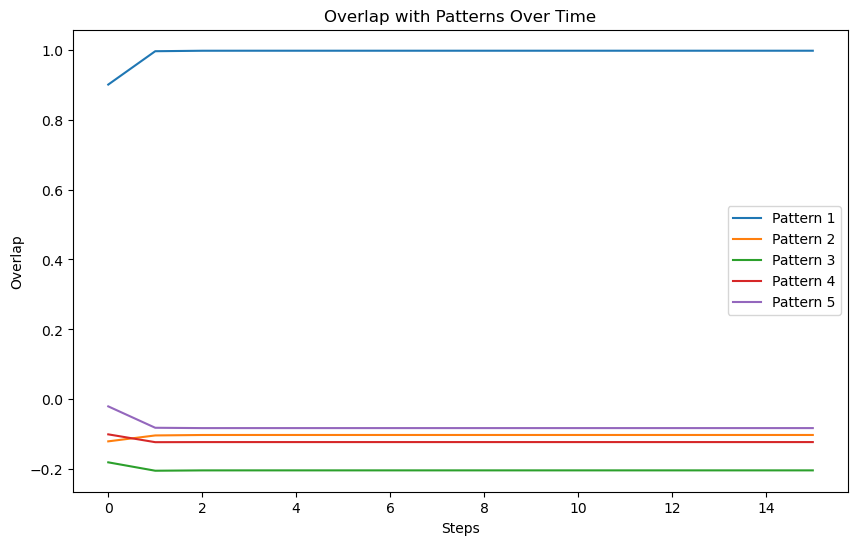

The network correctly retrieves the first pattern.


In [4]:
N = 100  # Number of neurons
M = 5  # Number of patterns
n = 15 # Number of steps
patterns = generate_patterns(M, N)

# Flipping 5% of indices
initial_state = patterns[0,:].copy()
c = 0.05
flip_indices = np.random.choice(len(initial_state), int(N*c), replace=False)
initial_state[list(flip_indices)] *= -1

S = initial_state
overlaps = np.zeros((n + 1, M))
for m in range(M):
    overlaps[0, m] = np.dot(S, patterns[m]) / N

for i in range(n):
    S, __ = next_state(S, patterns, beta=4)
    for m in range(M):
        overlaps[i + 1, m] = np.dot(S, patterns[m]) / N

# Plotting the overlaps
plt.figure(figsize=(10, 6))
for m in range(M):
    plt.plot(overlaps[:, m], label=f'Pattern {m+1}')
plt.xlabel('Steps')
plt.ylabel('Overlap')
plt.title('Overlap with Patterns Over Time')
plt.legend()
plt.show()

# Checking if the network correctly retrieves the first pattern
if np.abs(np.dot(S, patterns[0]) / N) > 0.95:
    print("The network correctly retrieves the first pattern.")
else:
    print("The network does not correctly retrieve the first pattern.")
    

# Ex 1. Storage capacity in the standard Hopfield network

**1.1.** Write a method that computes the next state S(t + 1) of the network, given the current state S(t),
and a set of M patterns P^µ.

In [13]:
def next_state_optimised(S, patterns, beta=4):
    """
    Args:
        S: state of the sequence
        patterns: array of M patterns (each an array of size N)
        beta: constant for the tanh function
    Output:
        The new state of neurones computed as a weighted sum of overlaps with 
        the patterns to represent the effective field at each neurone
    """
    N = len(S) #number of neurones
    M = len(patterns) #number of patterns
    m = np.zeros(M) #overlap variables
    
    # calculating overlap variables:
    for mu in range(M):
        m[mu] = np.dot(patterns[mu],S) / N
    
    # updating state:
    new_S_optimised = np.zeros(N)
    for i in range(N):
        input_field = np.dot(patterns[:,i], m)
        new_S_optimised[i] = np.tanh(beta*input_field)
        
    return new_S_optimised

What is the gain in the computational cost of a single update step?


In [17]:
import timeit

time = timeit.timeit(lambda: next_state(initial_state, patterns, beta=4), number=10)
time_optimised = timeit.timeit(lambda: next_state_optimised(initial_state, patterns, beta=4), number=10)

# calculating computational gain
comp_gain = time / time_optimised
print(f"Computational Gain: {comp_gain:.2f}x faster")

ns = next_state(initial_state, patterns, beta=4)
nso = next_state_optimised(initial_state, patterns, beta=4)
# checking if the states are similar
difference = np.linalg.norm(ns[0]-nso)
print(f"Difference between states: {difference}")

Computational Gain: 207.98x faster
Difference between states: 0.0


**1.2.** Write a method that computes the distance between two given patterns (using the Hamming distance)

In [18]:
def distance_hamming(P_mu, P_nu):
    """
    Args:
        P_mu: first pattern
        P_nu: second pattern
    Output:
        Normalised Hamming distance between two input patterns
    """
    N = len(P_mu) #number of neurones
    
    # calculating Hamming distance 
    hamming_distance = (N - np.dot(P_mu, P_nu)) / (2*N)
    
    return hamming_distance

What does this distance correspond to? What is the relationship with the overlap that we defined in the
lectures?

The Hamming distance corresponds to the number of neurones that differ in states between two patterns. It can be used for assessing the memory retrieval accuracy within the network, by quantifying how much the final state of the network deviates from the original pattern after the network processes and updates it.

The overlap defined in lectures calculates a normalised correlation between two patters, which represents their overall similarity. Higher overlap corresponds to fewer differences, therefore the relationship between the Hamming distance and the overlap is inversely proportional.

**1.3.** Create a Hopfield network with N = 300 neurons, in which M = 5 random patterns are stored.
Run the network for T = 20 steps after setting as the initial state the first of the random patterns with
15 of its bits flipped. Plot the evolution of the Hamming distance between the network’s state S(t) and
each of the patterns Pµ. Was the first pattern retrieved correctly by the network?

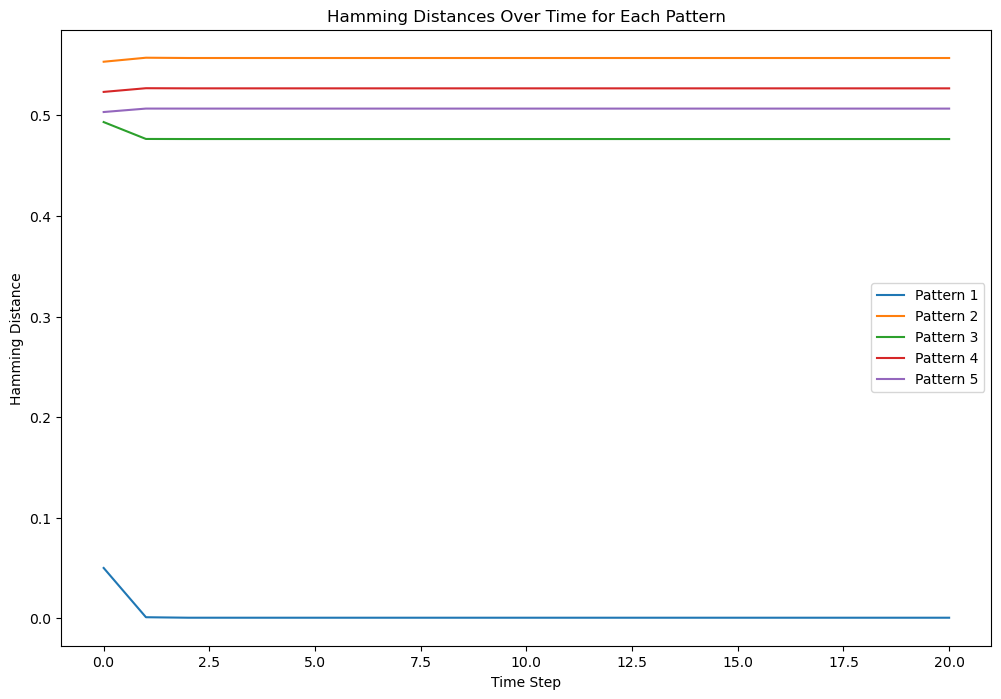

First pattern retrieval successful.
Final Hamming distance to first pattern: 0.0005263456002298502


In [19]:
N = 300  # number of neurones
M = 5    # number of patterns
patterns = generate_patterns(M, N)

# flipping 15 bits
initial_state = patterns[0,:].copy()
c = 15/N
flip_indices = np.random.choice(len(initial_state), int(N*c), replace=False)
initial_state[list(flip_indices)] *= -1

# calculating initial distances
initial_distances = []
for pattern in patterns: 
    initial_distance = distance_hamming(initial_state, pattern)
    initial_distances.append(initial_distance)
    
# simulating Hopfield network and calculating Hamming distances
T = 20 # number of steps    
current_state = initial_state
distances_hamming = [initial_distances]
for i in range(T):
    distances = []
    current_state = next_state_optimised(current_state, patterns, beta=4)
    for pattern in patterns:
        distance = distance_hamming(current_state, pattern)
        distances.append(distance)
    distances_hamming.append(distances)
    

# plotting evolution of Hamming distance between the network’s state and each of the patterns
plt.figure(figsize=(12, 8))
for pattern_index in range(M):  
    pattern_distances = []
    time_steps = [] 
    for t in range(T+1):
        pattern_distances.append(distances_hamming[t][pattern_index])
        time_steps.append(t) 

    plt.plot(time_steps, pattern_distances, label=f'Pattern {pattern_index + 1}')

plt.xlabel('Time Step')
plt.ylabel('Hamming Distance')
plt.title('Hamming Distances Over Time for Each Pattern')
plt.legend() 
plt.show()

# evaluating network's retrieval accuracy of first pattern
final_distance = distance_hamming(current_state, patterns[0])
retrieved_correctly = final_distance <= 0.05

if final_distance <= 0.05:
    print("First pattern retrieval successful.")
else:
    print("First pattern retrieval failed.")
# Output the result
print(f"Final Hamming distance to first pattern: {final_distance}")

**1.4.** For a dictionary of size M = 5, what are the mean and standard deviation (std) of the error of
pattern retrieval, and of the number of retrieved patterns? To compute them, iterate over 10-15 different
initialisations of the dictionary.

In [20]:
N = 300  # number of neurones
M = 5  # number of patterns
init = 15  # number of initialisations (10-15)
T = 50 # number of iterations

errors = []
successful_retrievals = []

for _ in range(init):
    patterns = generate_patterns(M, N)
    for pattern in patterns:
        # flipping 15 bits
        initial_state = pattern.copy()
        c = 15/N
        flip_indices = np.random.choice(len(initial_state), int(N*c), replace=False)
        initial_state[list(flip_indices)] *= -1

        # calculating initial distances
        initial_distances = []
        for mu in patterns:
            initial_distance = distance_hamming(initial_state, mu)
            initial_distances.append(initial_distance)
            
        # simulating Hopfield network and calculating Hamming distances
        current_state = initial_state
        distances_hamming = [initial_distances]
        for _ in range(T):
            distances = []
            current_state = next_state_optimised(current_state, patterns, beta=4)
            for mu in patterns:
                distance = distance_hamming(current_state, mu)
                distances.append(distance)
            distances_hamming.append(distances)
        
        # counting successful retrievals   
        successful_retrieval = 0
        for distance in distances_hamming[-1]:
            if distance <= 0.05:
                successful_retrieval += 1
        successful_retrievals.append(successful_retrieval)
        
        # calculating error
        error = sum(distances_hamming[-1]) / M
        errors.append(error)   

# calculating overall mean and std of errors and retrievals
mean_errors = np.mean(errors)
std_errors = np.std(errors, ddof=1)  
mean_retrievals = np.mean(successful_retrievals)
std_retrievals = np.std(successful_retrievals, ddof=1) 

# printing overall results
print(f"Mean Error: {mean_errors:.2f}")
print(f"Standard Deviation of Error: {std_errors:.2f}")
print(f"Mean Number of Retrieved Patterns: {mean_retrievals:.2f}")
print(f"Standard Deviation of Number of Retrieved Patterns: {std_retrievals:.2f}")

Mean Error: 0.40
Standard Deviation of Error: 0.01
Mean Number of Retrieved Patterns: 1.00
Standard Deviation of Number of Retrieved Patterns: 0.00


**1.5.** Repeat the previous question for dictionary sizes M varying from 5 to 80-100. Plot the error of
pattern retrieval and the number of retrieved patterns as a function of dictionary size. Use the standard
deviations to get error bars.

M = 5
Mean Error: 0.39865997160549277
Standard Deviation of Error: 0.012213808296056554
Mean Number of Retrieved Patterns: 1.0
Standard Deviation of Number of Retrieved Patterns: 0.0
M = 10
Mean Error: 0.451648831460573
Standard Deviation of Error: 0.008675235227484347
Mean Number of Retrieved Patterns: 1.0
Standard Deviation of Number of Retrieved Patterns: 0.0
M = 15
Mean Error: 0.46788794711353515
Standard Deviation of Error: 0.0070876940755839985
Mean Number of Retrieved Patterns: 1.0
Standard Deviation of Number of Retrieved Patterns: 0.0
M = 20
Mean Error: 0.47533390530634373
Standard Deviation of Error: 0.00709881599804259
Mean Number of Retrieved Patterns: 1.0
Standard Deviation of Number of Retrieved Patterns: 0.0
M = 25
Mean Error: 0.48064384844193475
Standard Deviation of Error: 0.00600489612183064
Mean Number of Retrieved Patterns: 1.0
Standard Deviation of Number of Retrieved Patterns: 0.0
M = 30
Mean Error: 0.4832905959216782
Standard Deviation of Error: 0.005670722923209

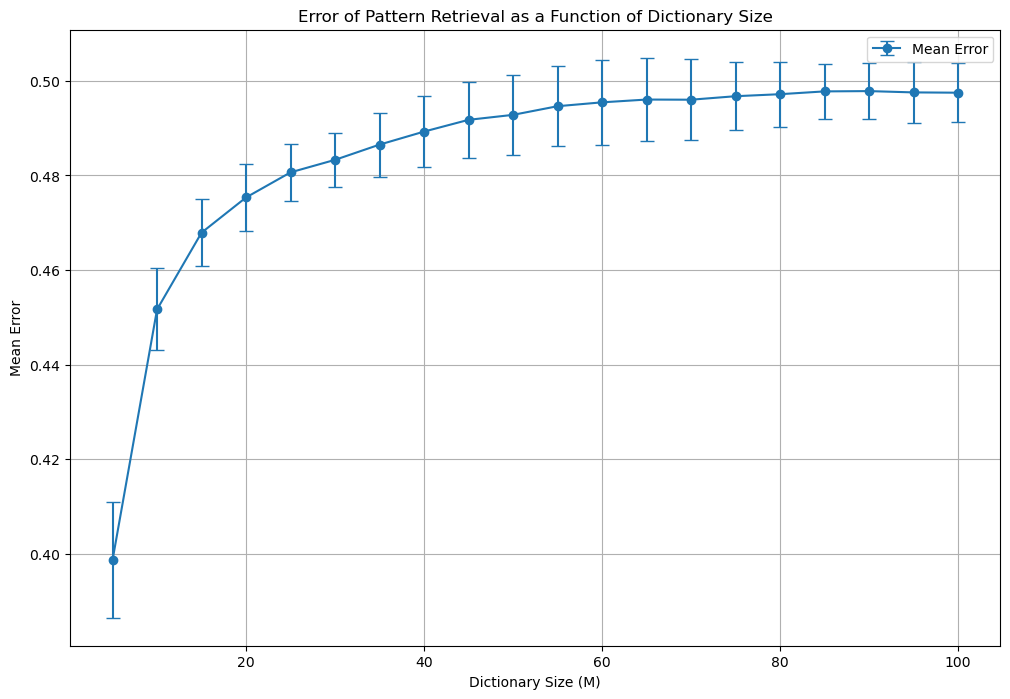

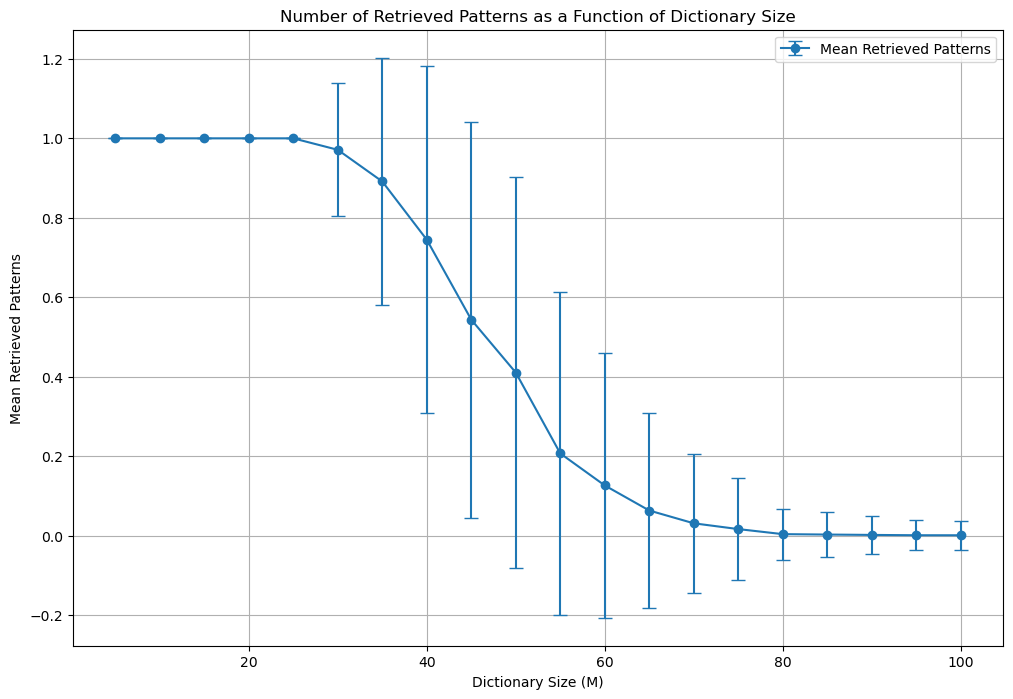

In [21]:
N = 300  # number of neurones
M = range(5,101,5)  # number of patterns
init = 15  # number of initialisations (10-15)
T = 50 # number of iterations

all_mean_errors = []
all_std_errors = []
all_mean_retrievals = []
all_std_retrievals = []

for m in M:
    errors = []
    successful_retrievals = []
    for _ in range(init):
        patterns = generate_patterns(m, N)
        for pattern in patterns:
            # flipping 15 bits
            initial_state = pattern.copy()
            c = 15/N
            flip_indices = np.random.choice(len(initial_state), int(N*c), replace=False)
            initial_state[list(flip_indices)] *= -1

            # calculating initial distances
            initial_distances = []
            for mu in patterns:
                initial_distance = distance_hamming(initial_state, mu)
                initial_distances.append(initial_distance)
            
            # simulating Hopfield network and calculating Hamming distances
            current_state = initial_state
            distances_hamming = [initial_distances]
            for _ in range(T): 
                distances = []
                current_state = next_state_optimised(current_state, patterns, beta=4)
                for mu in patterns:
                    distance = distance_hamming(current_state, mu)
                    distances.append(distance)
                distances_hamming.append(distances)
            
            # counting successful retrievals   
            successful_retrieval = 0
            for distance in distances_hamming[-1]:
                if distance <= 0.05:
                    successful_retrieval += 1
            successful_retrievals.append(successful_retrieval)
            
            # calculating error
            error = sum(distances_hamming[-1]) / m
            errors.append(error)   
    
    # calculating overall mean and std of errors and retrievals
    mean_errors = np.mean(errors)
    std_errors = np.std(errors, ddof=1)  
    mean_retrievals = np.mean(successful_retrievals)
    std_retrievals = np.std(successful_retrievals, ddof=1) 

    # storing results
    all_mean_errors.append(mean_errors)
    all_std_errors.append(std_errors)
    all_mean_retrievals.append(mean_retrievals)
    all_std_retrievals.append(std_retrievals)
    
    # printing overall results
    print(f"M = {m}")
    print(f"Mean Error: {mean_errors}")
    print(f"Standard Deviation of Error: {std_errors}")
    print(f"Mean Number of Retrieved Patterns: {mean_retrievals}")
    print(f"Standard Deviation of Number of Retrieved Patterns: {std_retrievals}")

# plotting mean errors
plt.figure(figsize=(12, 8))
plt.errorbar(M, all_mean_errors, yerr=all_std_errors, fmt='o-', capsize=5, label='Mean Error')
plt.xlabel('Dictionary Size (M)')
plt.ylabel('Mean Error')
plt.title('Error of Pattern Retrieval as a Function of Dictionary Size')
plt.legend()
plt.grid(True)
plt.show()

# plotting mean retrieved patterns
plt.figure(figsize=(12, 8))
plt.errorbar(M, all_mean_retrievals, yerr=all_std_retrievals, fmt='o-', capsize=5, label='Mean Retrieved Patterns')
plt.xlabel('Dictionary Size (M)')
plt.ylabel('Mean Retrieved Patterns')
plt.title('Number of Retrieved Patterns as a Function of Dictionary Size')
plt.legend()
plt.grid(True)
plt.show()

**1.6.** What is the maximal number of patterns Mmax that can be stored and retrieved in the network?
What happens to the retrieval error if the number of stored patterns increases beyond Mmax? Why?

In [22]:
M_max = int(0.138*N)

print(f"The maximal number of patterns Mmax that can be stored and retrieved in the network of {N} neurons is approximately {M_max}.")


The maximal number of patterns Mmax that can be stored and retrieved in the network of 300 neurons is approximately 41.


If the number of stored patterns increases beyond $M_{max}$, the retrieval error increases. The reason for this is the increase in the overlap within the synaptic weight matrix, due to the additional patterns, causing more interference during retrieval. This results in poorer network performance with its limited capacity to distinguish between similar states and the increase in interference amongst the patterns.

**1.7.** For different network sizes N from 50 to 800, plot the number of retrieved patterns per dictionary
divided by N as a function of the loading L. How does the capacity depend on the network size? Is this
what you would expect?

N = 50, L = 0.1
Mean Number of Retrieved Patterns: 1.0, Standard Deviation: 0.0
N = 50, L = 0.2
Mean Number of Retrieved Patterns: 0.69, Standard Deviation: 0.4648231987117317
N = 50, L = 0.3
Mean Number of Retrieved Patterns: 0.32666666666666666, Standard Deviation: 0.4705653698879759
N = 50, L = 0.4
Mean Number of Retrieved Patterns: 0.19, Standard Deviation: 0.39328535039354173
N = 50, L = 0.5
Mean Number of Retrieved Patterns: 0.116, Standard Deviation: 0.32086729857243584
N = 100, L = 0.1
Mean Number of Retrieved Patterns: 0.95, Standard Deviation: 0.21904291355759037
N = 100, L = 0.2
Mean Number of Retrieved Patterns: 0.425, Standard Deviation: 0.4955835096887071
N = 100, L = 0.3
Mean Number of Retrieved Patterns: 0.11333333333333333, Standard Deviation: 0.3175294822993921
N = 100, L = 0.4
Mean Number of Retrieved Patterns: 0.015, Standard Deviation: 0.12170468386708859
N = 100, L = 0.5
Mean Number of Retrieved Patterns: 0.02, Standard Deviation: 0.14014021035061358
N = 150, L = 

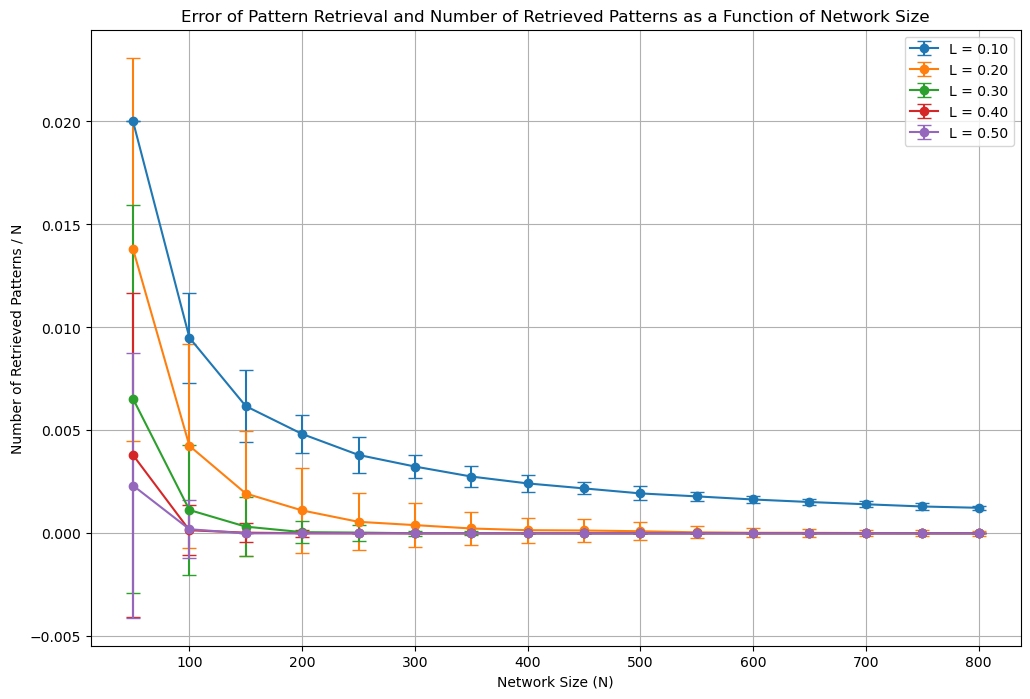

In [23]:
N = range(50,801,50)  # number of neurones
L = [0.1, 0.2, 0.3, 0.4, 0.5] # loading values of the network
init = 10  # number of initialisations (10-15)
T = 50 # number of iterations

number_of_neurones = []
loading_values = []
all_mean_retrievals = []
all_std_retrievals = []

for n in N:
    for l in L:
        M = int(l*n)
        successful_retrievals = []
        for _ in range(init):
            patterns = generate_patterns(M, n)
            for pattern in patterns:
                # flipping 5% bits
                initial_state = pattern.copy()
                c = 0.05
                flip_indices = np.random.choice(len(initial_state), int(n*c), replace=False)
                initial_state[list(flip_indices)] *= -1

                # calculating initial distances
                initial_distances = []
                for mu in patterns:
                    initial_distance = distance_hamming(initial_state, mu)
                    initial_distances.append(initial_distance)
        
                # simulating Hopfield network and calculating Hamming distances
                current_state = initial_state
                distances_hamming = [initial_distances]
                for _ in range(T): 
                    distances = []
                    current_state = next_state_optimised(current_state, patterns, beta=4)
                    for mu in patterns:
                        distance = distance_hamming(current_state, mu)
                        distances.append(distance)
                    distances_hamming.append(distances)
                
                # counting successful retrievals   
                successful_retrieval = 0
                for distance in distances_hamming[-1]:
                    if distance <= 0.05:
                        successful_retrieval += 1
                successful_retrievals.append(successful_retrieval) 
        
        # calculating overall mean and std of errors and retrievals 
        mean_retrievals = np.mean(successful_retrievals)
        std_retrievals = np.std(successful_retrievals, ddof=1) 

        # storing results
        number_of_neurones.append(n)
        loading_values.append(l)
        all_mean_retrievals.append(mean_retrievals)
        all_std_retrievals.append(std_retrievals)
        
        # printing results
        print(f"N = {n}, L = {l}")
        print(f"Mean Number of Retrieved Patterns: {mean_retrievals}, Standard Deviation: {std_retrievals}")

# plotting the results 
plt.figure(figsize=(12, 8))
for l in L:
    N_subset = []
    mean_retrievals_subset = []
    std_retrievals_subset = []

    for i in range(len(loading_values)):
        if loading_values[i] == l:
            N_subset.append(number_of_neurones[i])
            mean_retrievals_subset.append(all_mean_retrievals[i])
            std_retrievals_subset.append(all_std_retrievals[i])

    N_subset = np.array(N_subset)
    mean_retrievals_subset = np.array(mean_retrievals_subset)
    std_retrievals_subset = np.array(std_retrievals_subset)

    plt.errorbar(N_subset, mean_retrievals_subset/N_subset, yerr=std_retrievals_subset/N_subset, fmt='o-', capsize=5, label=f'L = {l:.2f}')
plt.xlabel('Network Size (N)')
plt.ylabel('Number of Retrieved Patterns / N')
plt.title('Error of Pattern Retrieval and Number of Retrieved Patterns as a Function of Network Size')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

**1.7.** (Bonus) How does the inverse temperature β in eq.(2) affect the network capacity?

The inverse temperature β in eq.(2) serves as a scaling factor of the input to the neurone's activation function Φ. β has an optimal range of values, that maximise the Hopfield network's ability to retrieve patterns. Below this range, β reduces the sensitivity of Φ, leading to neurone outputs being less distinct and less stable, as they are highly influenced by noise. If β is too high, the function becomes too sensitive with very rigid outputs, eventually leading to a plateau in retrieval performance of the model, where a further increase in β has no effect on the network capacity.

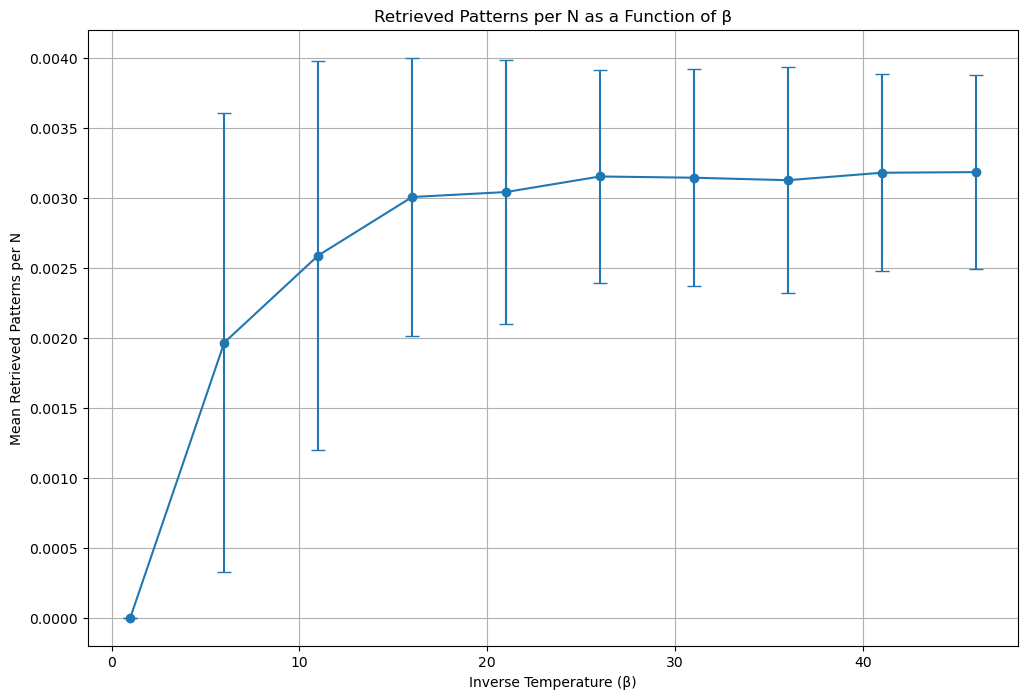

In [24]:
N = 300  # number of neurones
M = 50  # number of patterns
init = 15  # number of initialisations (10-15)
T = 50 # number of iterations
beta = range(1, 51, 5) 

mean_retrievals = []
std_retrievals = []

for b in beta:
    successful_retrievals = []
    for _ in range(init):
        patterns = generate_patterns(M, N)
        for pattern in patterns:
            # flipping 5% bits
            initial_state = pattern.copy()
            c = 0.05
            flip_indices = np.random.choice(len(initial_state), int(N*c), replace=False)
            initial_state[list(flip_indices)] *= -1
    
            # calculating initial distances
            initial_distances = []
            for mu in patterns:
                initial_distance = distance_hamming(initial_state, mu)
                initial_distances.append(initial_distance)
                
            # simulating Hopfield network and calculating Hamming distances
            current_state = initial_state
            distances_hamming = [initial_distances]
            for _ in range(T):
                current_state = next_state_optimised(current_state, patterns, beta=b)
            
            # counting successful retrievals   
            successful_retrieval = 0
            for mu in patterns:
                distance = distance_hamming(current_state, mu)
                if distance <= 0.05:
                    successful_retrieval += 1
            successful_retrievals.append(successful_retrieval)

    mean_retrieval = np.mean(successful_retrievals)/N
    mean_retrievals.append(mean_retrieval)
    std_retrieval = np.std(successful_retrievals, ddof=1)/N 
    std_retrievals.append(std_retrieval)

# plotting results
plt.figure(figsize=(12, 8))
plt.errorbar(beta, mean_retrievals, yerr=std_retrievals, fmt='o-', capsize=5)
plt.xlabel('Inverse Temperature (β)')
plt.ylabel('Mean Retrieved Patterns per N')
plt.title('Retrieved Patterns per N as a Function of β')
plt.grid(True)
plt.show()